# Machine Learning to Classify Insincere Quora Questions

**The aim is to be able to classify questions as sincere vs insincere using different features of the text and the question text itself. We will try Machine learning classification algorithms to solve the problem.**

In [20]:
import pandas as pd
import swifter
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

In [3]:
data = pd.read_csv('final_processed_df.csv')

In [4]:
data.head()

,qid,question_text,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,processed_text,len_after,num_words_after,len_ratio,num_words_ratio
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72,2,0.027778,13,13,1.0000,0,1,0,0,quebec nationalist see province nation,38,5,1.894737,2.600000
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81,1,0.012346,16,15,0.9375,0,1,1,0,adopt dog would encourage people adopt not shop,47,8,1.723404,2.000000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67,2,0.029851,10,8,0.8000,0,2,0,0,velocity affect time velocity affect space geo...,51,7,1.313725,1.428571
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57,4,0.070175,9,9,1.0000,0,1,0,0,otto von guericke use magdeburg hemisphere,42,6,1.357143,1.500000
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77,3,0.038961,15,15,1.0000,0,1,0,0,convert montra helicon mountain bike change tyre,48,7,1.604167,2.142857


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 18 columns):
qid                      1306122 non-null object
question_text            1306122 non-null object
target                   1306122 non-null int64
length                   1306122 non-null int64
capitals                 1306122 non-null int64
caps_vs_length           1306122 non-null float64
num_words                1306122 non-null int64
num_unique_words         1306122 non-null int64
words_vs_unique          1306122 non-null float64
num_exclamation_marks    1306122 non-null int64
num_question_marks       1306122 non-null int64
num_punctuation          1306122 non-null int64
num_symbols              1306122 non-null int64
processed_text           1305749 non-null object
len_after                1306122 non-null int64
num_words_after          1306122 non-null int64
len_ratio                1306122 non-null float64
num_words_ratio          1306122 non-null float64
dtypes: floa

In [6]:
def float_to_int(x):
    if x == float('inf') or x == float('-inf'):
        return float(0) # or a large value you choose
    return int(x)

data.len_ratio = data.len_ratio.swifter.apply(float_to_int)
data.num_words_ratio = data.num_words_ratio.swifter.apply(float_to_int)

data.processed_text = data.processed_text.fillna('')

In [7]:
data.describe()

,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,len_after,num_words_after,len_ratio,num_words_ratio
count,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06
mean,6.187018e-02,7.067884e+01,2.860756e+00,4.557576e-02,1.280361e+01,1.213578e+01,9.666687e-01,1.742563e-03,1.057475e+00,2.904055e-01,1.543730e-02,4.271438e+01,6.453952e+00,1.206526e+00,1.660784e+00
std,2.409197e-01,3.878428e+01,2.573325e+00,3.919927e-02,7.052437e+00,6.040779e+00,5.687022e-02,4.676167e-02,2.588720e-01,7.637911e-01,1.502499e-01,2.517267e+01,3.730951e+00,5.222969e-01,6.736842e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,9.523810e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,1.000000e+00,2.000000e-02,8.000000e+00,8.000000e+00,9.354839e-01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01,4.000000e+00,1.000000e+00,1.000000e+00
50%,0.000000e+00,6.000000e+01,2.000000e+00,3.389831e-02,1.100000e+01,1.100000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.600000e+01,5.000000e+00,1.000000e+00,2.000000e+00
75%,0.000000e+00,8.500000e+01,4.000000e+00,5.882353e-02,1.500000e+01,1.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.300000e+01,8.000000e+00,1.000000e+00,2.000000e+00
max,1.000000e+00,1.017000e+03,1.800000e+02,1.000000e+00,1.340000e+02,9.600000e+01,1.000000e+00,5.000000e+00,1.000000e+01,3.500000e+01,2.000000e+01,6.840000e+02,6.900000e+01,8.100000e+01,2.800000e+01


**Working with the whole dataset, with about 3 million rows will be daunting and we have a very small proportion of insincere questions in the dataset, which makes it very imbalanced. One way to overcome these problems is to work with only a subset of the data and train the models on a smaller subset of the whole dataset. We can keep all the insincere questions as we want to be able to classify those correctly and keep randomly selected sincere questions (twice as many as insincere questions). This would help us retain the imbalance in the data as well.**

In [8]:
sincere_df = data[data['target']==0]
insincere_df = data[data['target']==1]

In [9]:
sincere_df_subset = sincere_df.sample(n=160000)

In [10]:
insincere_df = insincere_df.reset_index()
sincere_df_subset = sincere_df_subset.reset_index()

In [11]:
sincere_df_subset.shape

(160000, 19)

In [12]:
subset = pd.concat([sincere_df_subset, insincere_df],0)
subset = subset.drop(['index'],1)
subset.head()

,qid,question_text,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,processed_text,len_after,num_words_after,len_ratio,num_words_ratio
0,9c71d04db446b9c42848,What does it mean if your wife replaces an old...,0,137,1,0.007299,26,25,0.961538,0,1,0,0,mean wife replace old wedding photo profession...,73,11,1.0,2.0
1,b89128604273a5e5c084,How did imperialism lead to nationalism in WW1?,0,47,3,0.063830,8,8,1.000000,0,1,0,0,imperialism lead nationalism ww,31,4,1.0,2.0
2,e07feb5fec19528f62a8,What is corridor wiring?,0,24,1,0.041667,4,4,1.000000,0,1,0,0,corridor wiring,15,2,1.0,2.0
3,1065d21c73bc4decc098,How can I lose lower body fat?,0,30,2,0.066667,7,7,1.000000,0,1,0,0,lose low body fat,17,4,1.0,1.0
4,d61f070b360910b2b3c5,Are psychometrics used to create state standar...,0,91,2,0.021978,15,15,1.000000,0,2,1,0,psychometric use create state standard not cou...,62,9,1.0,1.0


In [13]:
subset.shape

(240810, 18)

**Out of the 3 million rows (questions) we have now taken a subset of 240801 questions with sincere and insincere questions in the ratio of 2:1**

In [14]:
#split the data
X = subset.processed_text
y = subset.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((168567,), (168567,), (72243,), (72243,))

## Logistic Regression
* First, we want to try out the most basic classification algorithm which is logistic regression. In this case, we are using the TF-IDF vectorizer to vectorize our text data (the questions). We will look at different scoring metrics and compare them across different models to compare model performances.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5,1,'Confusion Matrix')

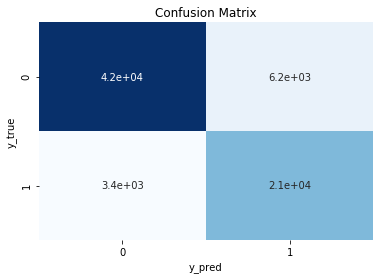

In [15]:
tf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
lr = LogisticRegression()
pipeline_lr = Pipeline([('tfidf', tf_vec), ('lr', lr)])
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

ax = plt.gca()
sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

In [16]:
print( 'accuracy score:',accuracy_score(y_test, y_pred))
acc_score={}
acc_score['Logistic Regression'] = accuracy_score(y_test, y_pred)

accuracy score: 0.8679041568041195


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     48081
           1       0.77      0.86      0.81     24162

   micro avg       0.87      0.87      0.87     72243
   macro avg       0.85      0.87      0.86     72243
weighted avg       0.87      0.87      0.87     72243



In [18]:
y_prob = pipeline_lr.predict_proba(X_test)
from sklearn.metrics import f1_score
best_threshold = 0
f1=0
for i in np.arange(.1, .51, 0.01):
    y_pred = [1 if proba>i else 0 for proba in y_prob[:, 1]]
    f1score = f1_score(y_pred, y_test)
    if f1score>f1:
        best_threshold = i
        f1=f1score
        
y_pred = [1 if proba>best_threshold else 0 for proba in y_prob[:, 1]]
f1 = f1_score(y_test, y_pred)
print('The best threshold is {}, with an F1 score of {}'.format(best_threshold, f1))

The best threshold is 0.47999999999999976, with an F1 score of 0.8140039524160112


Text(0.5,0,'False Positive Rate')

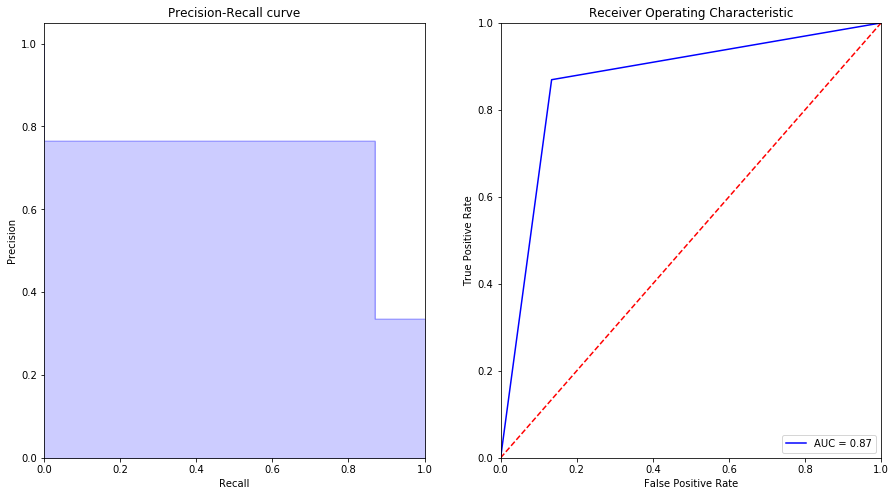

In [21]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

## Naive Bayes
* Next, we will try and fit our data to a probabilistic classifier, Naive Bayes Classifier which is based on Bayes probability theorem. We will look at similiar scoring metrics and compare this with the previous model.

In [22]:
mb = MultinomialNB()
pipeline_mb = Pipeline([ ('vectorizer', tf_vec), ('mb', mb)])

pipeline_mb.fit(X_train, y_train)
y_pred = pipeline_mb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,45792,2289
insincere,9483,14679


In [23]:
print( 'accuracy score:',accuracy_score(y_test, y_pred))
acc_score['Naive Bayes'] = accuracy_score(y_test, y_pred)

accuracy score: 0.8370499563971596


In [24]:
score = cross_val_score(pipeline_mb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     48081
           1       0.87      0.61      0.71     24162

   micro avg       0.84      0.84      0.84     72243
   macro avg       0.85      0.78      0.80     72243
weighted avg       0.84      0.84      0.83     72243



Text(0.5,0,'False Positive Rate')

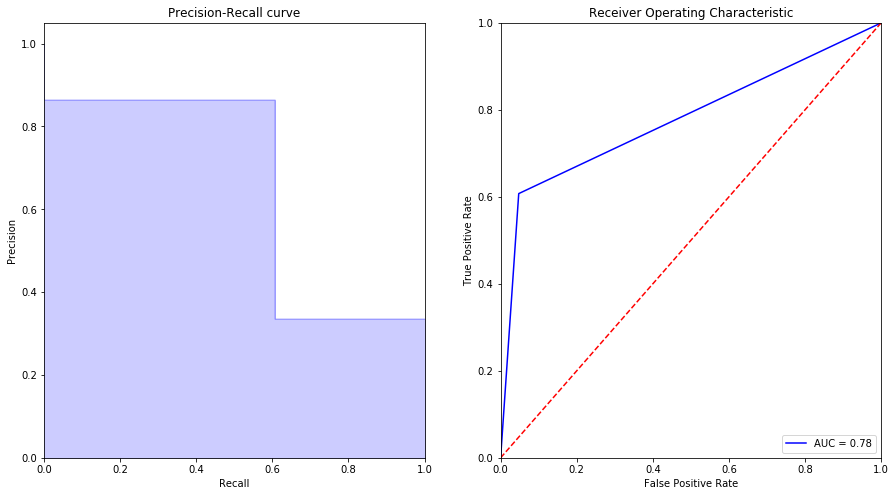

In [25]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

## KNN
* K-Nearest Neighbors classifier

In [26]:
knn = KNeighborsClassifier()
pipeline_knn = Pipeline([ ('vectorizer', tf_vec), ('mb', knn)])

pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,47837,244
insincere,23333,829


In [27]:
print( 'accuracy score:',accuracy_score(y_test, y_pred))
acc_score['KNN'] = accuracy_score(y_test, y_pred)

accuracy score: 0.6736431211328433


In [28]:
score = cross_val_score(pipeline_mb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.99      0.80     48081
           1       0.77      0.03      0.07     24162

   micro avg       0.67      0.67      0.67     72243
   macro avg       0.72      0.51      0.43     72243
weighted avg       0.71      0.67      0.56     72243



Text(0.5,0,'False Positive Rate')

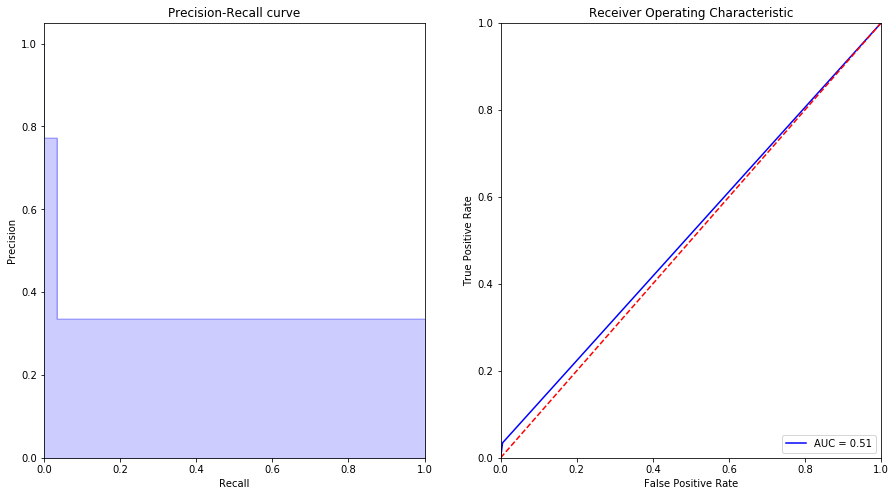

In [29]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

## XG Boost
* We also wanted to try boosting algorithm and chose to fit our data to extreme gradient boosting algorithm and assessed the performance of the model on our dataset.

In [30]:
xgbc = xgb.XGBClassifier() 
pipeline_xgb = Pipeline([ ('vectorizer', tf_vec), ('mb', xgbc)])

pipeline_xgb.fit(X_train, y_train)
y_pred = pipeline_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,46218,1863
insincere,13016,11146


In [31]:
print( 'accuracy score:',accuracy_score(y_test, y_pred))
acc_score['XGBoost'] = accuracy_score(y_test, y_pred)

accuracy score: 0.7940423293606301


In [32]:
score = cross_val_score(pipeline_xgb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86     48081
           1       0.86      0.46      0.60     24162

   micro avg       0.79      0.79      0.79     72243
   macro avg       0.82      0.71      0.73     72243
weighted avg       0.81      0.79      0.77     72243



Text(0.5,0,'False Positive Rate')

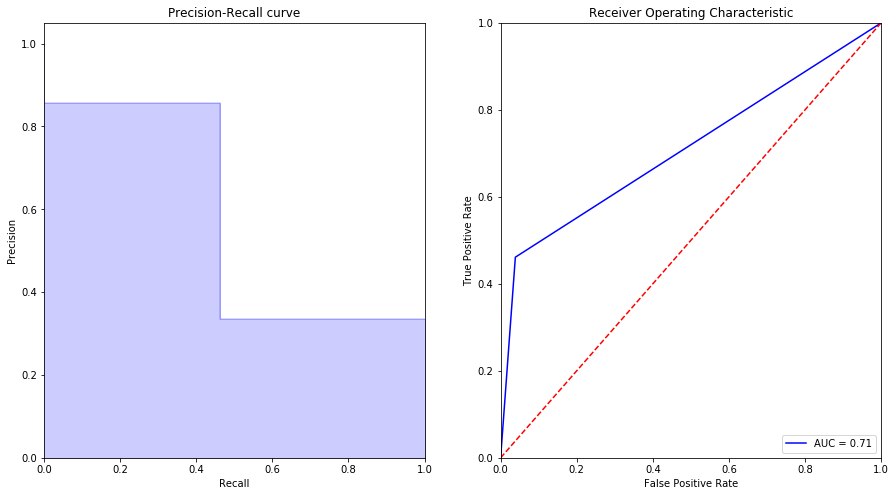

In [33]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

## SVD - Singular Value Decomposition
* SVD is used to get rid of redundant data for dimensionality reduction. We tried to implement SVD on our subset of the dataset and visualized the model.

In [34]:
count_vec = CountVectorizer(stop_words='english', ngram_range=(1, 3))
svd = TruncatedSVD(n_components=100, random_state=6)
tf_vec = TfidfVectorizer(stop_words='english')

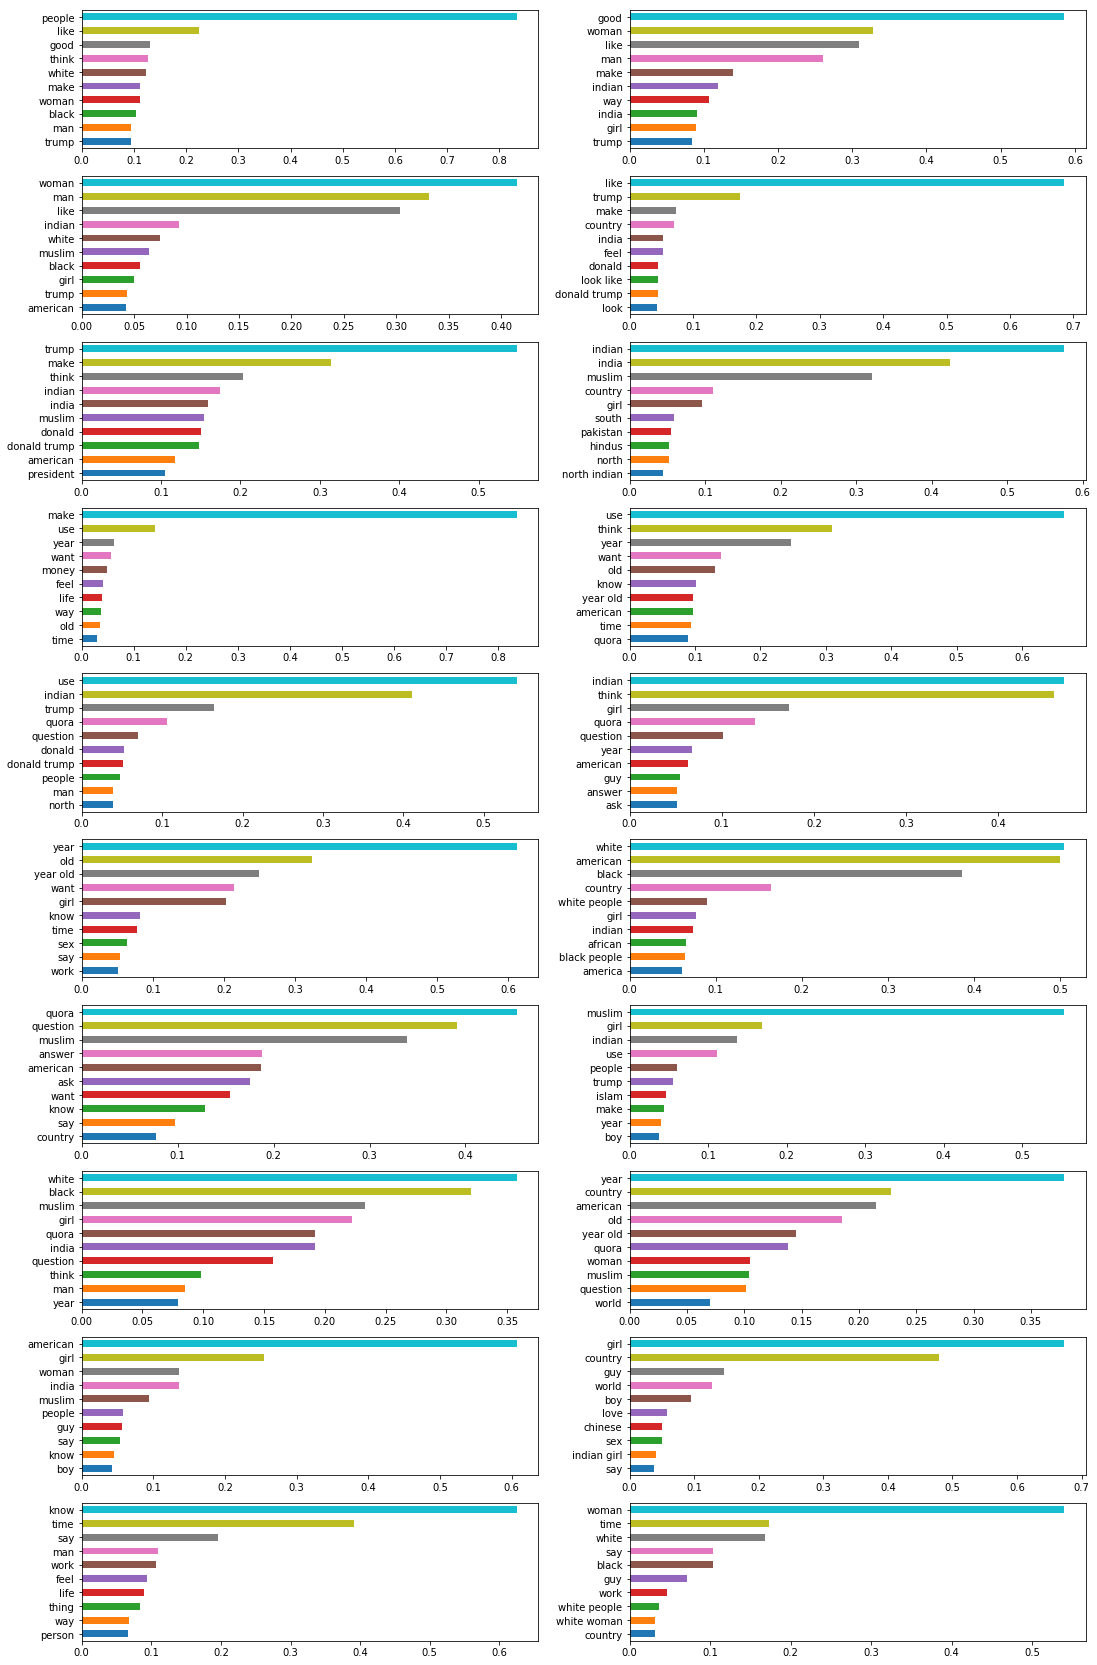

In [35]:
pipeline = Pipeline([('vectorizer', count_vec),('svd', svd)])
model = pipeline.fit_transform(X_train)

components = pd.DataFrame(data=svd.components_, columns=pipeline.named_steps['vectorizer'].get_feature_names())

fig, axes = plt.subplots(10, 2, figsize=(18, 30))
for i, ax in enumerate(axes.flat):
    components.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)
    

In [37]:
acc_score

{'Logistic Regression': 0.8679041568041195,
 'Naive Bayes': 0.8370499563971596,
 'KNN': 0.6736431211328433,
 'XGBoost': 0.7940423293606301}

In [51]:
scores = pd.DataFrame(acc_score, index=[0])
scores = scores.T
scores.sort_values([0], ascending=False, inplace=True)
scores

,0
Logistic Regression,0.867904
Naive Bayes,0.837050
XGBoost,0.794042
KNN,0.673643


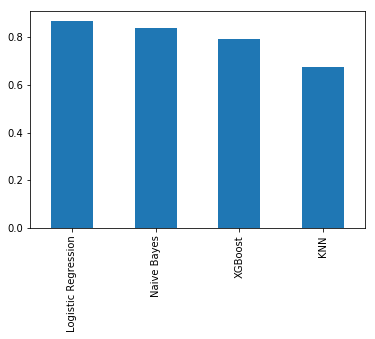

In [52]:
scores.plot(kind='bar')
*plt.legend().remove()

**Based on the above visualization, logistic regression seems to the best performing classification model and KNN seems to be the weakes model in terms of our data.**


## Logistic regression with all variables
* Previously, we also obtained other demographic features pertaining to the data which included the length, number of words, punctuation, etc. We want to try and include them in the analysis while fitting the model to test whether these demographic features are important features for our classification problem. We now include these features while fitting the data to logistic regression model, and visualize the feature importances.

In [35]:
subset_dropcols = subset.drop(['qid','question_text','target', 'processed_text'],1)

In [36]:
ngram = CountVectorizer(ngram_range=(3,3), max_df=0.50, min_df= 20)
ngram_matrix = ngram.fit_transform(subset.processed_text)

ngram_matrix = ngram_matrix.toarray()
vocab = ngram.get_feature_names()
ngram_df = pd.DataFrame(ngram_matrix, columns=vocab)

In [37]:
ngram_df=ngram_df.reset_index()
subset_dropcols =subset_dropcols.reset_index()
subset_ngram = pd.concat([subset_dropcols, ngram_df], 1)

In [38]:
subset_ngram = subset_ngram.drop(['index'],1)
subset_ngram.head()

,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,...,would world like,year old boy,year old daughter,year old girl,year old guy,year old male,year old man,year old son,year old woman,yearold girl bore
0,63,1,0.015873,13,13,1.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,106,1,0.009434,15,13,0.866667,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,1,0.014925,13,11,0.846154,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,63,1,0.015873,11,11,1.000000,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,63,1,0.015873,10,10,1.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
X = subset_ngram
y = subset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5,1,'Confusion Matrix')

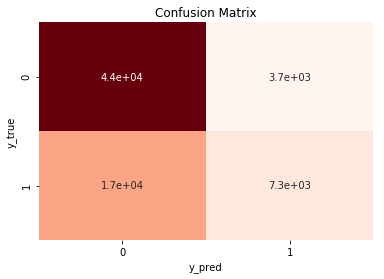

In [40]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

ax = plt.gca()
sns.heatmap(cm, cmap='Reds', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

In [ ]:
print( 'accuracy score:',accuracy_score(y_test, y_pred))
acc_score['LR - all features'] = accuracy_score(y_test, y_pred)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81     48081
           1       0.66      0.30      0.42     24162

   micro avg       0.72      0.72      0.72     72243
   macro avg       0.69      0.61      0.61     72243
weighted avg       0.70      0.72      0.68     72243



Text(0.5,0,'False Positive Rate')

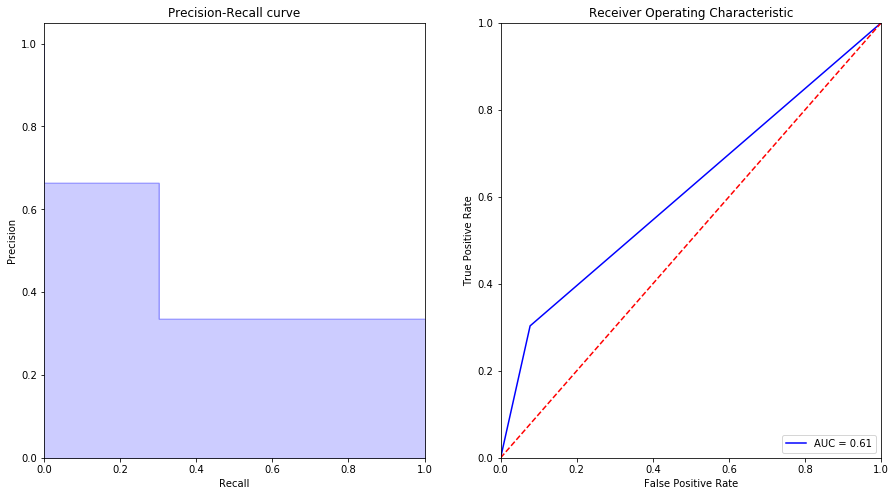

In [42]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

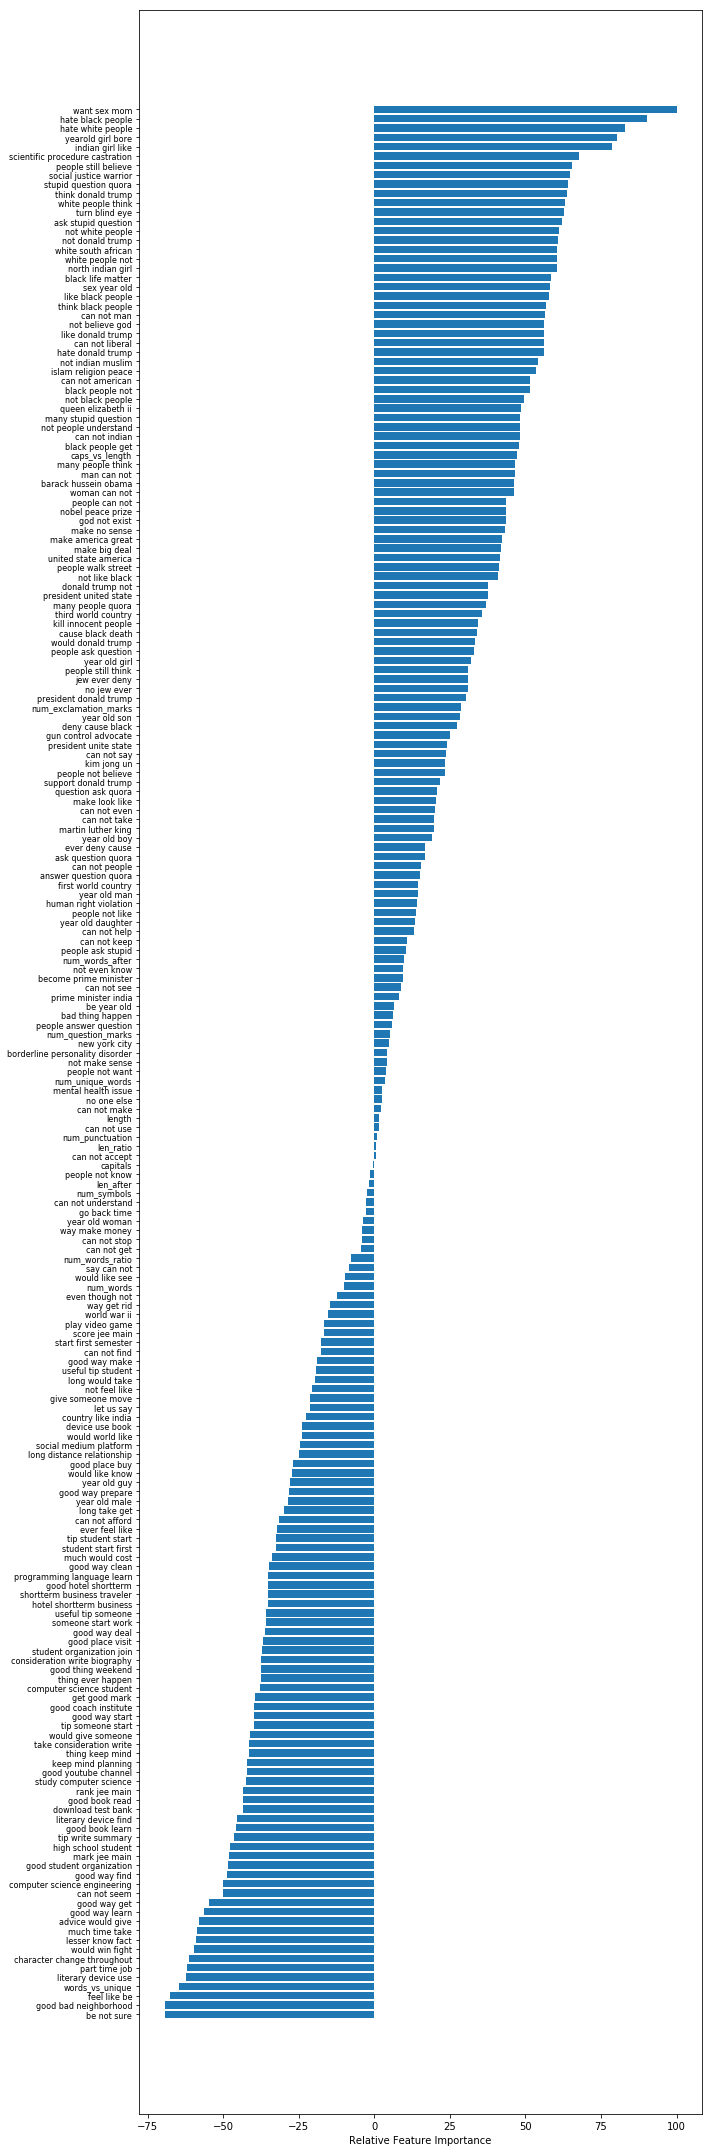

In [43]:
feature_importance = (lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,30))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

**Fom the above analysis and visualization we can conclude that the different demographic features do not hold much importance in our classification problem. They can be disregarded and we can focus solely on the actual text of the question to be able to effectively classify it as sincere vs insincere.**

# Deep Learning
* **We implemented different classifiers to clasify question as sincere vs insincere and we got good accuracy results. But, to enhance our classification algorithm, we can also try to implemet deep learning in the form of neural networks which would make the model more robust and result in better performance. First we will try a simple deep neural network with multiple layers and in the following network we will also try to implement LSTM and assess the classification performance.**

In [62]:
import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
import text_normalizer as tn
from nltk.tokenize import sent_tokenize
from collections import Counter

In [64]:
def text_preprocess(text):
    text = text.lower() 
    text = re.sub('[^a-zA-Z]', ' ', text) 
    text = re.sub(r'\s+', ' ', text)
    return text

In [65]:
X = subset.question_text
y = subset.target

X = X.swifter.apply(text_preprocess)

Pandas Apply: 100%|██████████| 240810/240810 [00:04<00:00, 55542.31it/s]


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((168567,), (168567,), (72243,), (72243,))

In [67]:
num_classes=2 
y_tr = le.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_tr, num_classes)

In [68]:
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(X_train, size=w2v_num_features, window=150, min_count=10, sample=1e-3)    

In [69]:
def avg_word2vec_vectorizer(text, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in text]
    return np.array(features)


In [70]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = avg_word2vec_vectorizer(text=X_train, model=w2v_model, num_features=500)
avg_wv_test_features = avg_word2vec_vectorizer(text=X_test, model=w2v_model, num_features=500)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [127]:
print('Word2Vec model: \n Train features shape:', avg_wv_train_features.shape)
print('Test features shape:', avg_wv_test_features.shape)

Word2Vec model:> Train features shape: (168567, 500)  Test features shape: (72243, 500)


In [128]:
def neural_network(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(num_input_features,)))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [208]:
w2v_dnn = neural_network(num_input_features=500)
w2v_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 512)               256512    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 1026      
__________

In [135]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=5, batch_size=batch_size, validation_split=0.1, verbose=1)

Train on 151710 samples, validate on 16857 samples
Epoch 1/5
151710/151710 [==============================] - 34s 227us/step - loss: 0.5654 - acc: 0.7047 - val_loss: 0.5507 - val_acc: 0.7214
Epoch 2/5
151710/151710 [==============================] - 33s 219us/step - loss: 0.5468 - acc: 0.7194 - val_loss: 0.5344 - val_acc: 0.7282
Epoch 3/5
151710/151710 [==============================] - 37s 246us/step - loss: 0.5412 - acc: 0.7239 - val_loss: 0.5318 - val_acc: 0.7377
Epoch 4/5
151710/151710 [==============================] - 37s 242us/step - loss: 0.5356 - acc: 0.7286 - val_loss: 0.5229 - val_acc: 0.7395
Epoch 5/5
151710/151710 [==============================] - 37s 245us/step - loss: 0.5309 - acc: 0.7317 - val_loss: 0.5200 - val_acc: 0.7439


In [136]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred) 

In [156]:
score = accuracy_score(y_test, predictions)
acc_score['Deep_nn'] = score
print(score)

0.7366250017302715


In [157]:
print(f1_score(y_test, predictions, average="macro"))
print(precision_score(y_test, predictions, average="macro"))
print(recall_score(y_test, predictions, average="macro")) 

0.7033914674925608
0.7039617892107415
0.7028452077653684


Text(0.5,1,'Confusion Matrix')

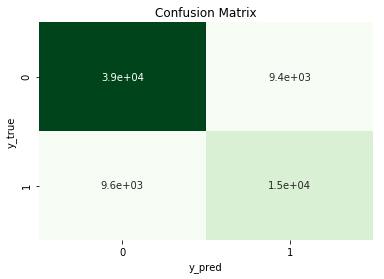

In [158]:
cm = confusion_matrix(y_test, predictions)

ax = plt.gca()
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

Text(0.5,0,'False Positive Rate')

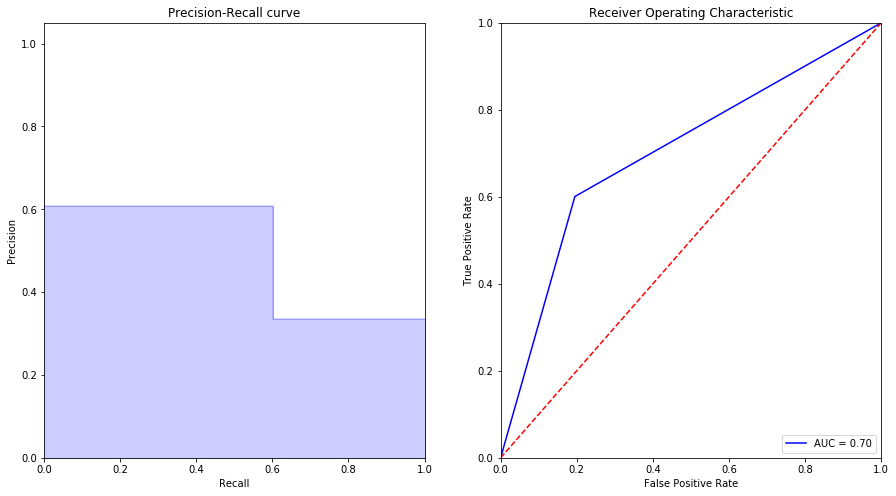

In [159]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, predictions)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

******
* Next, we want to use LSTM - Long Short-Term Memory Units which help preserve the error that can be backpropagated through time and layers. By maintaining a more constant error, they allow recurrent nets to continue to learn over many time steps.

In [101]:
import pandas as pd
import numpy as np
import text_normalizer as tn
from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.preprocessing import Normalizer

In [102]:
X = subset.question_text
y = subset.target

X = X.swifter.apply(text_preprocess)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Pandas Apply: 100%|██████████| 240810/240810 [00:04<00:00, 53255.71it/s]


((168567,), (168567,), (72243,), (72243,))

In [97]:
#norm_train_reviews = Normalizer(X_train)
#norm_test_reviews = Normalizer(X_test)

In [104]:
tokenizer = ToktokTokenizer()
#tokens = tokenizer.tokenize(text)

tokenized_train = [tokenizer.tokenize(text) for text in X_train]
tokenized_test = [tokenizer.tokenize(text) for text in X_test]

In [105]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 62336
Sample slice of vocabulary map: {'a': 11, 'seat': 12, 'iit': 13, 'madras': 14, 'do': 15, 'root': 16, 'samsung': 17, 'android': 18, 'phone': 19, 'what': 20}


In [106]:
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
## Train prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
train_y = le.fit_transform(y_train)

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
## Test prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
test_y = le.transform(y_test)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 139
Train review vectors shape: (168567, 139)  Test review vectors shape: (72243, 139)


In [107]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [108]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 139, 128)          7979008   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 139, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,028,481
Trainable params: 8,028,481
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
batch_size = 100
model.fit(train_X, train_y, epochs=5, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 151710 samples, validate on 16857 samples
Epoch 1/5
151710/151710 [==============================] - 2840s 19ms/step - loss: 0.2978 - acc: 0.8780 - val_loss: 0.2607 - val_acc: 0.8981
Epoch 2/5
151710/151710 [==============================] - 548s 4ms/step - loss: 0.2238 - acc: 0.9124 - val_loss: 0.2601 - val_acc: 0.8970
Epoch 3/5
151710/151710 [==============================] - 605s 4ms/step - loss: 0.1905 - acc: 0.9255 - val_loss: 0.2739 - val_acc: 0.8962
Epoch 4/5
151710/151710 [==============================] - 541s 4ms/step - loss: 0.1632 - acc: 0.9362 - val_loss: 0.2946 - val_acc: 0.8909
Epoch 5/5
151710/151710 [==============================] - 535s 4ms/step - loss: 0.1409 - acc: 0.9446 - val_loss: 0.3220 - val_acc: 0.8892


In [110]:
pred_test = model.predict_classes(test_X)
predictions = le.inverse_transform(pred_test.flatten())

In [116]:
score = accuracy_score(y_test, predictions)
acc_score['lstm'] = score
print(score)

0.8886674141439309


In [112]:
print(f1_score(y_test, predictions, average="macro"))
print(precision_score(y_test, predictions, average="macro"))
print(recall_score(y_test, predictions, average="macro")) 

0.8750336695069123
0.8748149963479799
0.8752538222801916


Text(0.5,1,'Confusion Matrix')

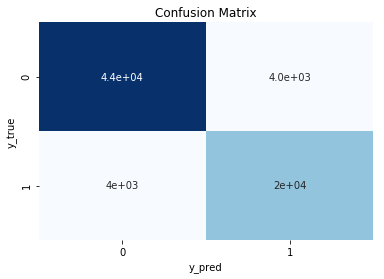

In [113]:
cm = confusion_matrix(y_test, predictions)

ax = plt.gca()
sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

Text(0.5,0,'False Positive Rate')

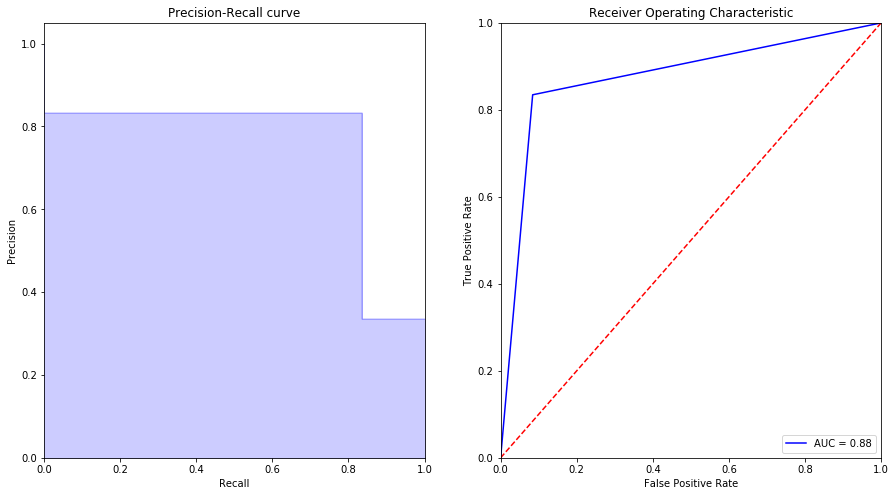

In [114]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, predictions)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

In [117]:
scores = pd.DataFrame(acc_score, index=[0])
scores = scores.T
scores.sort_values([0], ascending=False, inplace=True)
scores

,0
lstm,0.888667
Logistic Regression,0.867904
Naive Bayes,0.837050
XGBoost,0.794042
Deep_nn,0.736625
KNN,0.673643


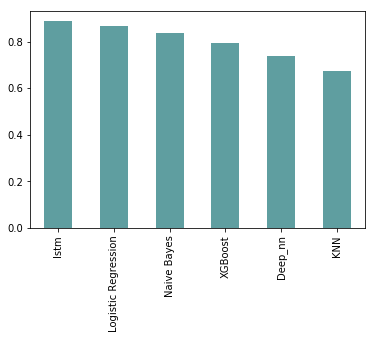

In [120]:
scores.plot(kind='bar', color='cadetblue')
plt.legend().remove()